(example_4)=
# Example 4: Learning causal coupling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

```{admonition} Authors
:class: tip

- Lina Walkowiak, Aarhus University, Denmark ([202205493@post.au.dk](202205493@post.au.dk))
- Nicolas Legrand, Aarhus University, Denmark ([nicolas.legrand@cas.au.dk](nicolas.legrand@cas.au.dk))
```

In [1509]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [1510]:
%load_ext autoreload
%autoreload 2

from functools import partial
from typing import Callable, Dict, NamedTuple, Optional, Tuple

import jax
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from jax import Array, jit

from pyhgf import load_data
from pyhgf.math import gaussian_surprise, sigmoid, gaussian_density
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.model.network import Network
from pyhgf.typing import Edges
from pyhgf.utils import beliefs_propagation
from pyhgf.updates.prediction_error.continuous import continuous_node_prediction_error

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction
In this notebook, we implement a model that incorporates causal coupling. 
We simulate two time series, where one has a causal influence on the other, where the magnitude of the influence is changing over time. The HGF model takes these two time series as inputs, which are provided to the two continuous state nodes that are causally coupled. The strength of this coupling is dynamically updated based on the provided observations. 


## Simulating a data set

We create two synthetic time series, $x_1$ and  $x_2$, where $x_1$ is an independent random walk and $x_2$ depends on $x_1$ with three varying levels of influence: strong, medium, and low. This approach allows us to model a dynamic causal relationship between the series, with dependency strengths changing in the three different phases. We add noise to each phase, with the noise level increasing and thereby the dependency weakens.

$$
\begin{align*} 
    x_1 & \sim \mathcal{N}(0.0, 0.2) \\
    x_2 & \sim \mathcal{N}(0.0, 0.2) \\
    x_2 & = x_2 + \alpha x_1
\end{align*} 
$$

In [1511]:
np.random.seed(123)

# Parameters
n_samples = 1000

# Generate x_1 and x_2 as a random walk
x1 = np.cumsum(np.random.normal(0, 0.02, n_samples)) + 2.0
x2 = np.random.normal(0, 0.02, n_samples)

# Coupling vector
coupling = np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0, 0.2, 0.8, 0.0, 1.0]).repeat(
    n_samples / 10
)

# Update x_2 so it is influenced by x_1 according to the coupling vector
x2 = x2 + coupling * x1

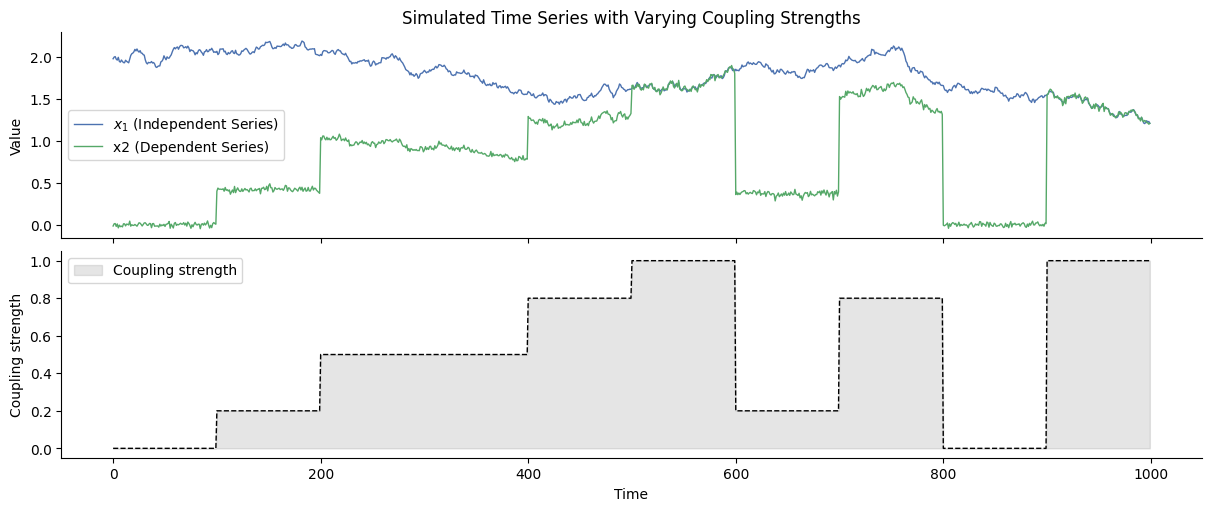

In [1512]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)
axs[0].plot(x1, label=r"$x_1$ (Independent Series)", color="#4c72b0", linewidth=1)
axs[0].plot(x2, label="x2 (Dependent Series)", color="#55a868", linewidth=1)
axs[0].set(
    title="Simulated Time Series with Varying Coupling Strengths", ylabel="Value"
)
axs[0].legend()

axs[1].plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs[1].fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs[1].set(xlabel="Time", ylabel="Coupling strength")
axs[1].legend()
sns.despine();

## Creating the network

Here, we initialize one network with two input state nodes. Each state node is influenced by a value parent. The two nodes are independent of each other.

In [1513]:
# Initialize two independent HGFs for X1 and X2
non_causal_hgf = (
    Network()
    .add_nodes(precision=1e1, n_nodes=2)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
)

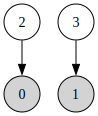

In [1514]:
non_causal_hgf.plot_network()

In [1515]:
# Input the time series
input_data = np.array([x1, x2]).T
non_causal_hgf.input_data(input_data=input_data);

Array(6542.0293, dtype=float32)

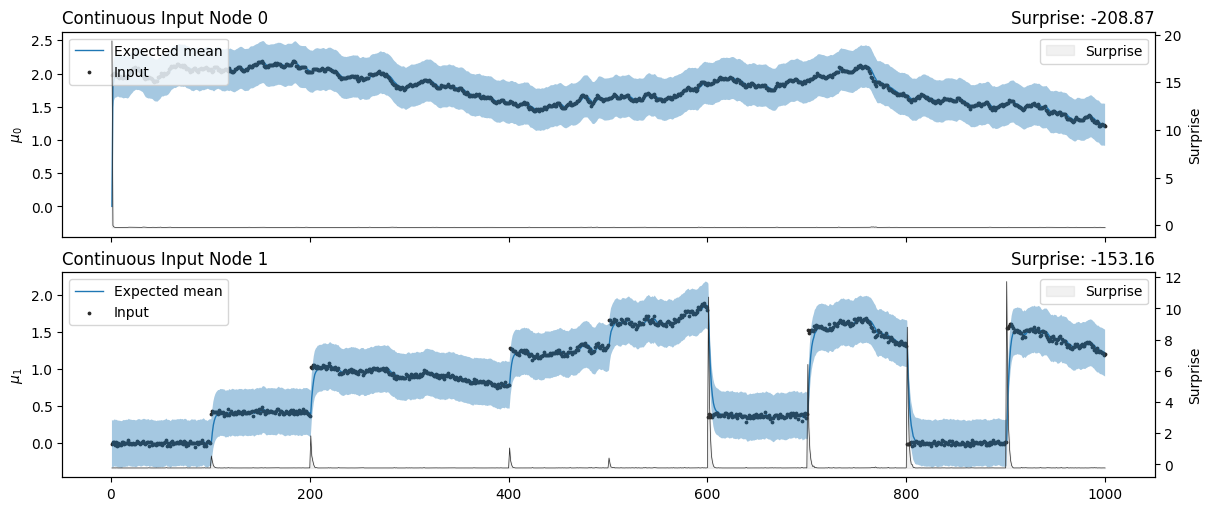

In [1516]:
# Plot trajectories for each HGF
non_causal_hgf.plot_nodes(node_idxs=[0, 1]);
non_causal_hgf.surprise(response_function=first_level_gaussian_surprise).sum()



## Causal coupling model

In this section, we create a coupled HGF model to capture the causal influence of the variable $x_1$ on the variable $x_2$. This setup now implies learning the strength of a causal connection between $x_1$ and $x_2$, which should reflect the actual value used for the simulations above. We therefore use the same model as a starting point and will add an extra step in the update sequence to learn the causal coupling strength over time.

In [1517]:
# Initialize a causal HGF
causal_hgf = (
    Network()
    .add_nodes(precision=1e1, n_nodes=2, tonic_volatility = 2)
    .add_nodes(value_children=0, precision=1e1)
    .add_nodes(value_children=1, precision=1e1)
)

### Add a causal connection between the two nodes

In [1518]:
# Add the coupling strength in the node attributes
causal_hgf.attributes[0]["causal_coupling_children"] = jnp.array([0.0])

In [1519]:
# Update the edges variable so it stores the index of the causal child
edges = list(causal_hgf.edges)
adjacency_list = edges[0]

In [1520]:
# Create a new adjacency variable for this case
class CausalAdjacencyLists(NamedTuple):
    node_type: int
    value_parents: Optional[Tuple]
    volatility_parents: Optional[Tuple]
    value_children: Optional[Tuple]
    volatility_children: Optional[Tuple]
    coupling_fn: Tuple[Optional[Callable], ...]
    causal_children: Optional[Tuple]


causal_adjacency_list = CausalAdjacencyLists(
    node_type=adjacency_list.node_type,
    value_parents=adjacency_list.value_parents,
    volatility_parents=adjacency_list.volatility_parents,
    value_children=adjacency_list.value_children,
    volatility_children=adjacency_list.volatility_children,
    coupling_fn=adjacency_list.coupling_fn,
    causal_children=(1,),
)

In [1521]:
# Insert the new variable back to the edges
edges[0] = causal_adjacency_list
causal_hgf.edges = tuple(edges)

### Create the causal update function

Now that the variables are in place in the network, we need to create a new update function that will estimate the causal strength between the two variables at each belief propagation.

In [1522]:
@partial(jit, static_argnames=("node_idx", "edges"))
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
) -> Array:
    r"""Update the causal strength between this node and all causal children.

    Parameters
    ----------
    attributes :
        The attributes of the probabilistic nodes.
    node_idx :
        Pointer to the value parent node that will be updated.

    Returns
    -------
    attributes :
        The attributes of the probabilistic nodes.

    """
    # get the expected mean and precision from the causal parent
    parent_expected_mean = attributes[node_idx]["expected_mean"]
    parent_expected_precision = attributes[node_idx]["expected_precision"]

    # for all causal children, compute the new causal strength
    new_strengths = []
    for causal_child_idx, strength in zip(
        edges[node_idx].causal_children,
        attributes[node_idx]["causal_coupling_children"],
    ):

        # get children's expected mean and precision
        child_expected_mean = attributes[causal_child_idx]["expected_mean"]
        child_expected_precision = attributes[causal_child_idx]["expected_precision"]

        child_surprise = gaussian_surprise(
            x=attributes[causal_child_idx]["mean"],
            expected_mean=child_expected_mean,
            expected_precision=child_expected_precision,
        )
        combined_surprise = gaussian_surprise(
            x=attributes[causal_child_idx]["mean"],
            expected_mean=child_expected_mean + parent_expected_mean,
            expected_precision=child_expected_precision + parent_expected_precision,
        )
        new_strengths.append(child_surprise - combined_surprise)

    # update the strengths vector
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes

In [1523]:
# Add this step at the end of the belief propagation sequence
# Here we simply re-use the previous sequence as template
predictions, updates = non_causal_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
causal_hgf.update_sequence = (predictions, updates)
causal_hgf = causal_hgf.create_belief_propagation_fn()


## Fitting data and visualisation

In [1524]:
causal_hgf.input_data(input_data=input_data);

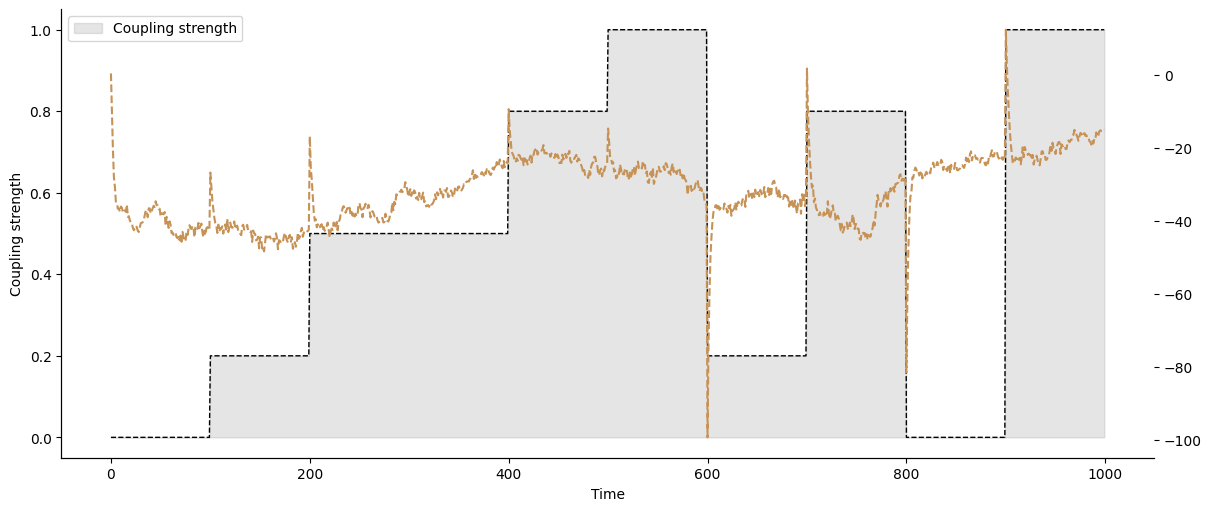

In [1525]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), sharex=True)

axs.plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs.fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs.set(xlabel="Time", ylabel="Coupling strength")
axs.legend()

coupling_ax = axs.twinx()
coupling_ax.plot(
    causal_hgf.node_trajectories[0]["causal_coupling_children"],
    label="Inferred coupling strength",
    color="#c69255",
    linestyle="--",
)




sns.despine();

### Update of the coupling strength 
The continuous_node_causal_strength function updates the causal coupling strength between a parent and its child nodes dynamically during belief propagation. The update rule combines the parent's state (reflected by the tanh of its mean to account for large values) and the child's precision-weighted prediction error, ensuring that changes in causal strength are proportional to both the parent's influence and the child's confidence in its prediction error. After updating, a sigmoid-like transformation rescales the strengths to keep them bounded between 0 and 1. 





In [1526]:
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
    learning_rate: float = 0.01,
    temperature: float = 1.0,
) -> Array:
    r"""
Causal coupling strength update.

The causal coupling strength \( w_{ij} \) is updated as follows:

1. **Update**:
   
   .. math:: 
        w_{ij}^{t} = w_{ij}^{t-1} + \eta \cdot \Delta_j \cdot \text{tanh}(\mu_i)

   where:
   - \( \eta \) is the learning rate.
   - \( \mu_i \) is the parent's expected mean.
   - \( \Delta_j \) is the precision-weighted PE.

2. **Rescaling with Sigmoid- transformation**:
   
   .. math::
       w_{ij} = \frac{x^\text{temperature}}{x^\text{temperature} + (1 - x)^\text{temperature}}

   where \( \text{temperature} = 1 \).

Parameters
----------
attributes :
    The attributes of the probabilistic nodes.
edges :
    The edges of the network.
node_idx :
    Index of the parent node whose causal coupling strengths are being updated.
learning_rate :
    The learning rate \( \eta \) for updating the edge weights.

Returns
-------
attributes :
    The updated attributes of the probabilistic nodes, including updated causal coupling strengths.
"""
    # Validate inputs and check for errors
    if node_idx not in attributes:
        raise ValueError(f"Node index {node_idx} not found in attributes.")
    
    # Get the expected mean and precision from the causal parent
    parent_expected_mean = attributes[node_idx]["expected_mean"]
    parent_expected_mean_tanh = jnp.tanh(parent_expected_mean)

    # Initialize list for new strengths
    new_strengths = []

    # Iterate over each causal child to calculate new (raw) strengths
    for causal_child_idx, strength in zip(
        edges[node_idx].causal_children,
        attributes[node_idx]["causal_coupling_children"],
    ):
        # Retrieve the prediction error and precision for the child
        prediction_error = attributes[causal_child_idx]["temp"]["value_prediction_error"]
        child_precision = attributes[causal_child_idx]["expected_precision"]

        # Compute precision-weighted PE
        precision_weighted_pe = prediction_error * child_precision

        # Update the strength for the edge between parent and child (raw update)
        update = learning_rate * precision_weighted_pe * parent_expected_mean_tanh
        raw_strength = strength + update

        # Rescale using the sigmoid-like transformation
        rescaled_strength = (raw_strength**temperature) / (
            raw_strength**temperature + (1 - raw_strength)**temperature
        )


        # Append the rescaled strength
        new_strengths.append(rescaled_strength)

    # Update causal coupling strengths for the parent node
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes


In [1527]:
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
    learning_rate: float = 0.01,
    temperature: float = 1.0,
) -> Array:
    # Validate inputs
    if node_idx not in attributes:
        raise ValueError(f"Node index {node_idx} not found in attributes.")
    
    # Get the expected mean and validate
    parent_expected_mean = attributes[node_idx]["expected_mean"]

    # Replace the invalid if statement with JAX-safe handling
    parent_expected_mean = jnp.where(
        jnp.isnan(parent_expected_mean), 0.0, parent_expected_mean
    )

    parent_expected_mean_tanh = jnp.tanh(parent_expected_mean)

    # Initialize list for new strengths
    new_strengths = []

    # Validate causal coupling children
    strengths = attributes[node_idx]["causal_coupling_children"]
    strengths = jnp.where(jnp.isnan(strengths), 0.0, strengths)

    # Transform strengths to desired scale before updates
    transformed_strengths = (strengths**temperature) / (
        strengths**temperature + (1 - strengths)**temperature
    )

    # Iterate over each causal child
    for causal_child_idx, transformed_strength in zip(
        edges[node_idx].causal_children, transformed_strengths
    ):
        # Retrieve and sanitize prediction error and precision
        prediction_error = attributes[causal_child_idx]["temp"]["value_prediction_error"]
        prediction_error = jnp.nan_to_num(prediction_error, nan=0.0)

        child_precision = attributes[causal_child_idx]["expected_precision"]
        child_precision = jnp.clip(child_precision, 1e-10, 1e5)

        # Compute precision-weighted PE
        precision_weighted_pe = prediction_error * child_precision

        # Update strength
        update = learning_rate * precision_weighted_pe * parent_expected_mean_tanh
        update = jnp.clip(update, -1.0, 1.0)
        updated_strength = transformed_strength + update

        # Transform updated strength back to the original scale
        updated_strength = jnp.clip(updated_strength, 1e-10, 1 - 1e-10)
        original_scale_strength = (updated_strength**(1 / temperature)) / (
            updated_strength**(1 / temperature)
            + (1 - updated_strength)**(1 / temperature)
        )

        new_strengths.append(original_scale_strength)

    # Update attributes with new strengths
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes


In [1528]:
predictions, updates = non_causal_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
causal_hgf.update_sequence = (predictions, updates)
causal_hgf = causal_hgf.create_belief_propagation_fn()
causal_hgf.create_belief_propagation_fn()


In [1529]:
causal_hgf.input_data(input_data=input_data);

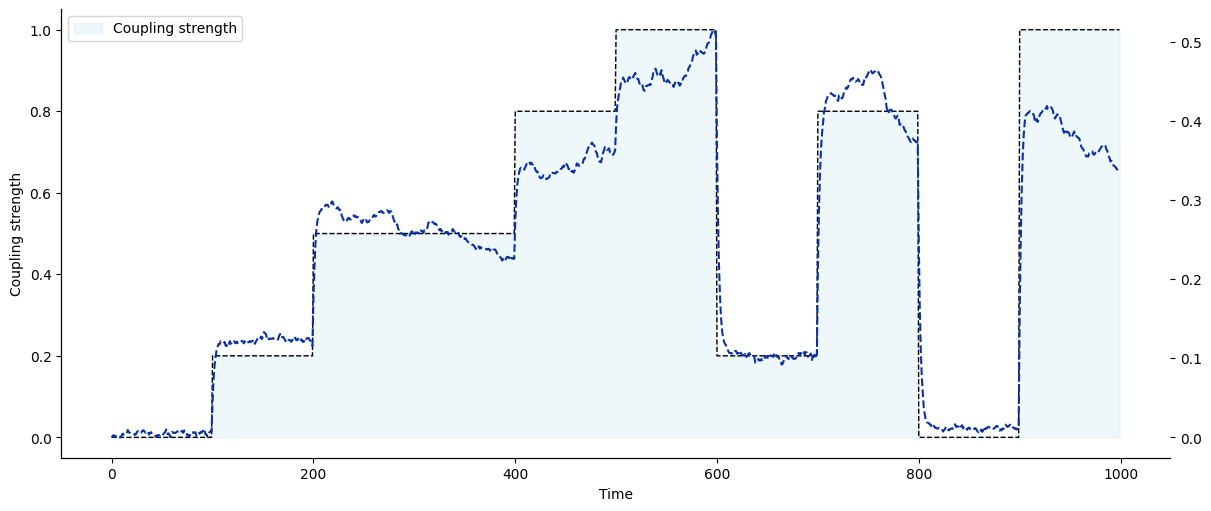

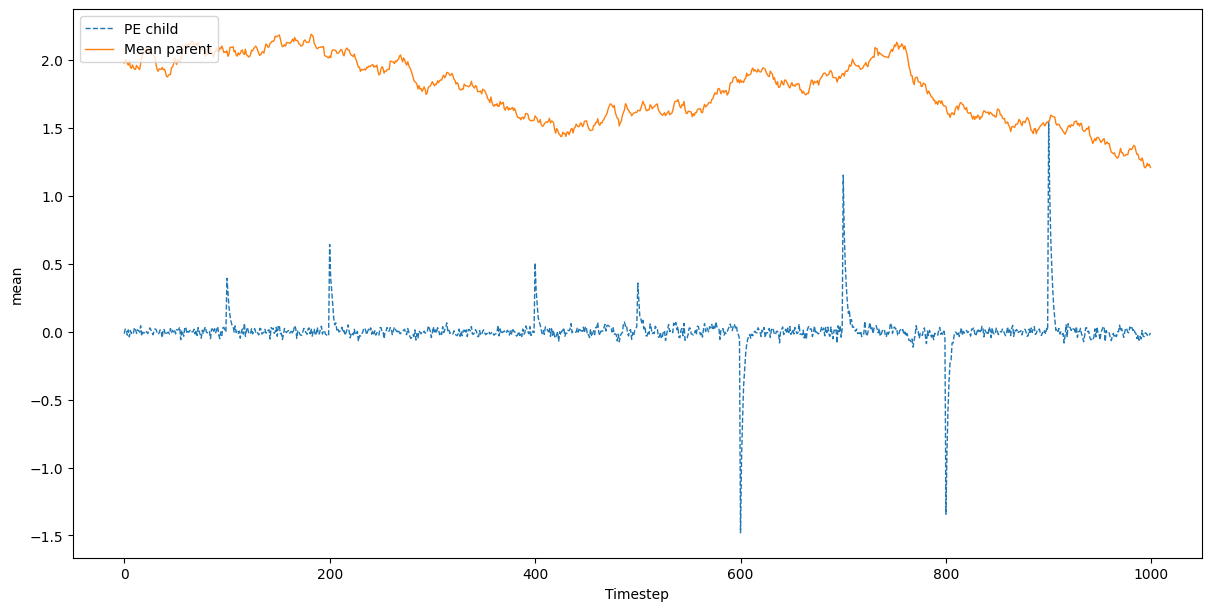

In [1530]:
# Plot the trajectories
_, axs = plt.subplots(figsize=(12, 5), sharex=True)

axs.plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs.fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="lightblue",
    alpha=0.2,
    label="Coupling strength",
)
axs.set(xlabel="Time", ylabel="Coupling strength")
axs.legend()

coupling_ax = axs.twinx()
coupling_ax.plot(
    causal_hgf.node_trajectories[0]["causal_coupling_children"], 
    label="Inferred coupling strength",
    color="#0B31A5",
    linestyle="--",
)

sns.despine();

# plot PE and mean over time
fig, axs = plt.subplots(figsize = (12, 6))

axs.plot(
    causal_hgf.node_trajectories[1]["temp"]['value_prediction_error'], 
    linestyle="--", 
    linewidth=1.0, 
    label="PE child"
)

axs.set(xlabel="Timestep", ylabel="PE")
axs.legend(loc="upper left")

axs.plot(
    causal_hgf.node_trajectories[0]['mean'], 
    linestyle="-", 
    linewidth=1.0, 
    label="Mean parent"
)

axs.set(xlabel="Timestep", ylabel="mean")
axs.legend(loc="upper left")

## Measuring freedom and control

The functions provided here serve as tools to measure the dependence between an agent's actions and the environmental states (as a proxy of freedom), as well as the influence of the agent's actions on future environmental states (a proxy of control). To quantify these dependencies, **KL divergence** is used as a measure of mutual information between Gaussian distributions. 
- The `construct_multivariate_gaussian_means_covariances` function creates a joint multivariate Gaussian distribution from a set of means, precisions, and correlations. 
- The `kl_divergence_multivariate_gaussian` function computes the KL divergence between two multivariate Gaussian distributions. 
- The `kl_divergence_univariate_gaussian` function computes the divergence between univariate Gaussians. 

Together, they are meant to capture the mutual information I(A; E) as well as the conditional mutual information I(S^t+1; A^t | S^t). 

In [1531]:
def construct_multivariate_gaussian_means_covariances(means, precisions, correlations):
    """
    Construct a multivariate Gaussian distribution for multiple correlated nodes.
    
    Args:
        means (list): List of means for each node.
        precisions (list): List of precisions (inverse variances) for each node.
        correlations (2D array or list of lists): Symmetric matrix of correlation coefficients (n x n).
    
    Returns:
        mean: Joint mean vector.
        cov: Joint covariance matrix.
        precision: Joint precision matrix (inverse covariance).
    """
    # Convert correlations to array if not already done
    correlations = np.array(correlations)
    
    # Convert precisions to variances
    variances = [1 / p for p in precisions]
    std_devs = [np.sqrt(var) for var in variances]
    
    # Get mean vector
    mean = np.array(means)
    
    # Construct covariance matrix
    n = len(means)
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i, j] = correlations[i, j] * std_devs[i] * std_devs[j]
    
    # Precision matrix
    precision = np.linalg.inv(cov)
    
    return mean, cov, precision


In [1532]:
from scipy.linalg import inv, det

def kl_divergence_multivariate_gaussian(mean_p, cov_p, mean_q, cov_q):
    """
    Compute KL divergence between two multivariate Gaussians.
    
    Args:
        mean_p: Mean vector of distribution p.
        cov_p: Covariance matrix of distribution p.
        mean_q: Mean vector of distribution q.
        cov_q: Covariance matrix of distribution q.
    
    Returns:
        KL divergence D_KL(p || q).
    """
    d = mean_p.shape[0]
    cov_q_inv = np.linalg.inv(cov_q)
    
    # Devide the terms to enhance reading
    term1 = np.log(np.linalg.det(cov_q) / np.linalg.det(cov_p))
    term2 = -d
    term3 = np.trace(cov_q_inv @ cov_p)
    term4 = (mean_q - mean_p).T @ cov_q_inv @ (mean_q - mean_p)
    
    return 0.5 * (term1 + term2 + term3 + term4)


In [1533]:
def kl_divergence_univariate_gaussian(mean_p, precision_p, mean_q, precision_q):
    """
    Compute the KL divergence between two univariate Gaussian distributions.

    Args:
        mean_p: Mean of the first Gaussian (P).
        precision_p: Precision (inverse variance) of the first Gaussian (P).
        mean_q: Mean of the second Gaussian (Q).
        precision_q: Precision (inverse variance) of the second Gaussian (Q).

    Returns:
        KL divergence D_KL(P || Q).
    """
    # Convert precision to variance
    variance_p = 1 / precision_p
    variance_q = 1 / precision_q
    
    # Compute KL divergence
    kl_divergence = 0.5 * (
        np.log(precision_q / precision_p)  
        - 1                               
        + precision_p / precision_q      
        + precision_q * (mean_p - mean_q)**2 
    )
    return kl_divergence

In [1534]:
def get_correlation_matrix(network):
    """
    Extract the correlation matrix of the sufficient statistics trajectories.

    Parameters
    ----------
    network : Network
        An instance of the HGF model.

    Returns
    -------
    correlation_mat : pd.DataFrame
        DataFrame containing the correlation matrix of model trajectories.
    """
    # Convert network trajectories to pandas DataFrame
    trajectories_df = network.to_pandas()
    
    # Filter relevant columns for sufficient statistics (means, expected, surprise)
    trajectories_df = pd.concat(
        [
            trajectories_df[["time"]],
            trajectories_df[
                [
                    f"x_{i}_mean"
                    for i in range(len(network.edges))
                    if i in network.input_idxs
                ]
            ],
            trajectories_df.filter(regex="expected"),
            trajectories_df.filter(regex="surprise"),
        ],
        axis=1,
    )

    # Compute correlation matrix
    correlation_mat = trajectories_df.corr()

    return correlation_mat



In [1535]:
# Get means and precisions for the nodes of interest
mean_0 = causal_hgf.node_trajectories[0]['mean'][2]
precision_0 = causal_hgf.node_trajectories[0]['precision'][2]

mean_1 = causal_hgf.node_trajectories[1]['mean'][2]
precision_1 = causal_hgf.node_trajectories[1]['precision'][5]

mean_2 = causal_hgf.node_trajectories[2]['mean'][5]
precision_2 = causal_hgf.node_trajectories[2]['precision'][5]

mean_3 = causal_hgf.node_trajectories[3]['mean'][5]
precision_3 = causal_hgf.node_trajectories[3]['precision'][5]

# Get correlations between nodes from the matrxi as defined above
# This is over all time steps, maybe this should be specific to the time point 
correlation_mat = get_correlation_matrix(causal_hgf)

# Extract correlations
rho_01 = correlation_mat.loc["x_0_expected_mean", "x_1_expected_mean"]
rho_23 = correlation_mat.loc["x_2_expected_mean", "x_3_expected_mean"]

# Construct multivariate Gaussian for each pair of nodes
# Node 1 and Node 3
mean_13, cov_13, precision_13 = construct_multivariate_gaussian_means_covariances(
    [mean_1, mean_3],
    [precision_1, precision_3],
    [[1.0, rho_01], [rho_01, 1.0]]
)

# Node 0 and Node 2
mean_02, cov_02, precision_02 = construct_multivariate_gaussian_means_covariances(
    [mean_0, mean_2],
    [precision_0, precision_2],
    [[1.0, rho_23], [rho_23, 1.0]]
)

# Step 4: Compute KL divergence between the two pairs
kl_13_02 = kl_divergence_multivariate_gaussian(mean_13, cov_13, mean_02, cov_02)

print(f"KL Divergence between [Node 1, Node 3] and [Node 0, Node 2]: {kl_13_02}")


KL Divergence between [Node 1, Node 3] and [Node 0, Node 2]: 96.91884187773871


In [1536]:
divergences = []
for t in range(len(causal_hgf.node_trajectories[0]['mean'])): 
    mean_0 = causal_hgf.node_trajectories[0]['mean'][t]
    precision_0 = causal_hgf.node_trajectories[0]['precision'][t]

    mean_1 = causal_hgf.node_trajectories[1]['mean'][t]
    precision_1 = causal_hgf.node_trajectories[1]['precision'][t]

    mean_2 = causal_hgf.node_trajectories[2]['mean'][t]
    precision_2 = causal_hgf.node_trajectories[2]['precision'][t]

    mean_3 = causal_hgf.node_trajectories[3]['mean'][t]
    precision_3 = causal_hgf.node_trajectories[3]['precision'][t]

    rho_01 = correlation_mat.loc["x_0_expected_mean", "x_1_expected_mean"]
    rho_23 = correlation_mat.loc["x_2_expected_mean", "x_3_expected_mean"]


    mean_13, cov_13, precision_13 = construct_multivariate_gaussian_means_covariances(
    [mean_1, mean_3],
    [precision_1, precision_3],
    [[1.0, rho_01], [rho_01, 1.0]]
    )
    mean_02, cov_02, precision_02 = construct_multivariate_gaussian_means_covariances(
    [mean_0, mean_2],
    [precision_0, precision_2],
    [[1.0, rho_23], [rho_23, 1.0]]
    )
    kl_13_02 = kl_divergence_multivariate_gaussian(mean_13, cov_13, mean_02, cov_02)
    divergences.append(kl_13_02)

    

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_11255/698418042.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


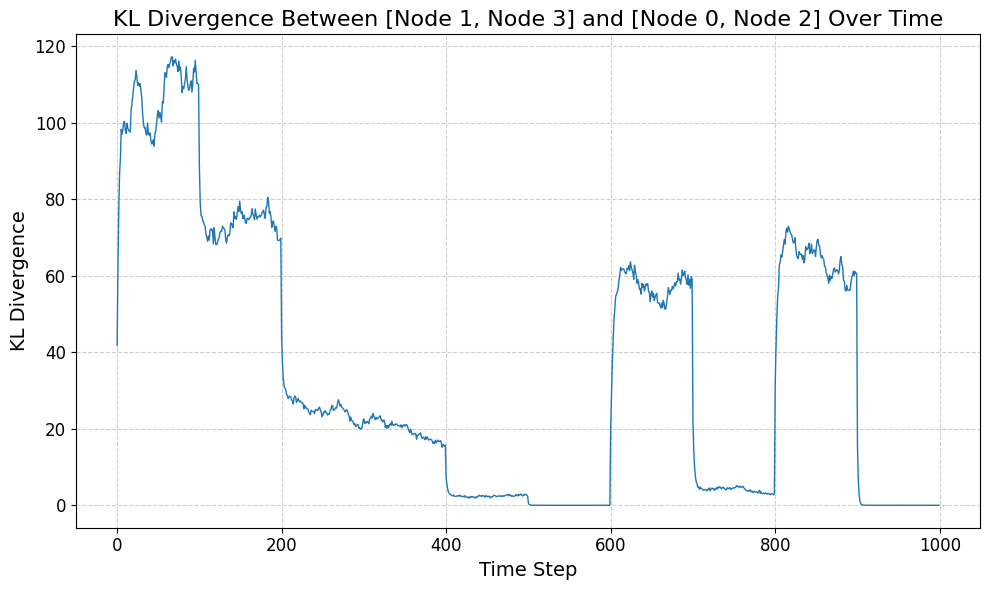

In [1537]:
# Plot KL divergences over time
plt.figure(figsize=(10, 6))  # Set a nice figure size
plt.plot(range(len(divergences)), divergences, linestyle='-', linewidth=1)

plt.xlabel("Time Step", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.title("KL Divergence Between [Node 1, Node 3] and [Node 0, Node 2] Over Time", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_11255/3650858724.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


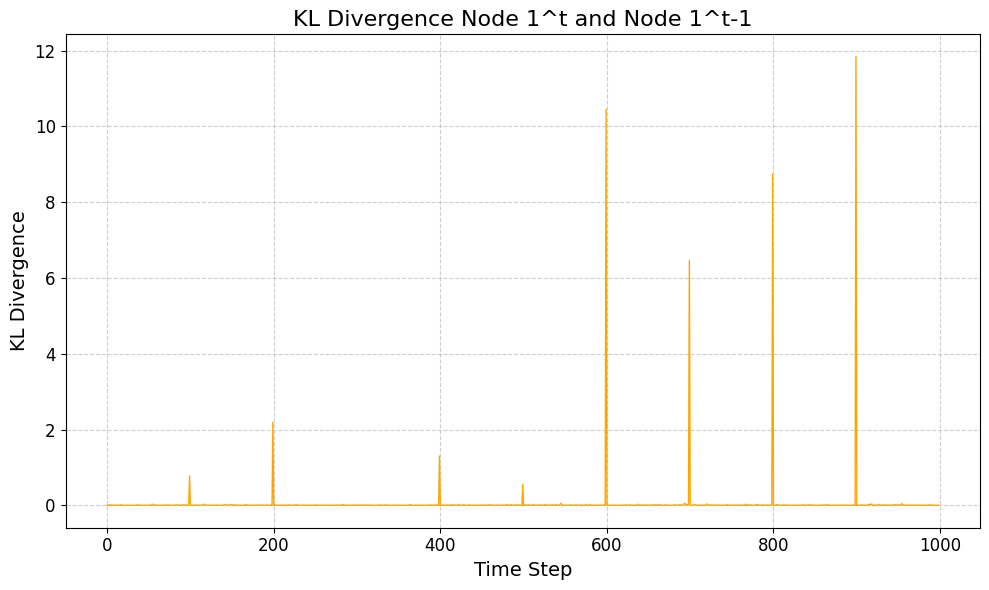

In [1538]:
# KL for node 1 and node 1 t+1 (MI(S^{t+1}|S^t))
mean_t_1 = causal_hgf.node_trajectories[1]['mean'][1:] 
mean_t = causal_hgf.node_trajectories[1]['mean'][:-1]
precision_t_1 = causal_hgf.node_trajectories[1]['precision'][1:] 
precision_t = causal_hgf.node_trajectories[1]['precision'][:-1]

kl_node_1 = kl_divergence_univariate_gaussian(mean_t_1, precision_t_1, mean_t, precision_t)

plt.figure(figsize=(10, 6))  # Set a nice figure size
plt.plot(kl_node_1, linestyle='-', linewidth=1, color='orange')

plt.xlabel("Time Step", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.title("KL Divergence Node 1^t and Node 1^t-1", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



## Action simulations of different agents

Here, I am trying to add the influence of actiosn. Decisions are supposed to influence the incoming observations, but right now the loop is not operating properly, so belief updates are not happening as they should (or at all).

#### Free agent

In [1539]:
# Initialize actions, updated input data, and logging for trajectories
actions = [0.0]
updated_input_data = x1.copy()

free_agent = (
    Network()
        .add_nodes(kind = "continuous-state", n_nodes=1, precision = 1e2)
        .add_nodes(value_children=0, precision = 1e2)
        .add_nodes(kind="continuous-state", volatility_children=1, precision=1e1)).create_belief_propagation_fn()


attributes, edges, update_sequence = (
    free_agent.get_network()
)


# Initialize storage for node metrics
node_0_expected_mean = []  
node_1_expected_mean = []
node_0_precision = []    
node_1_precision = []   
node_0_expected_precision = [] 
node_1_expected_precision = [] 
node_0_prediction_error = []   
node_1_prediction_error = []  

# Iterate over timesteps
for t in range(len(updated_input_data)):
    # Sample a new random action
    action = np.random.uniform(low=-1, high=1)
    actions.append(action)
    # Update input data for the current timestep
    updated_input_data[t] += coupling[t] * actions[t]
    inputs = tuple(np.column_stack((updated_input_data[t], np.ones_like(updated_input_data[t]))).ravel())

    # Update the network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=(*inputs, 1.0),
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=free_agent.input_idxs,
    )

    # Store metrics for node_0
    node_0_expected_mean.append(attributes[0]["expected_mean"])
    node_0_precision.append(attributes[0]["precision"])
    node_0_expected_precision.append(attributes[0]["expected_precision"])
    node_0_prediction_error.append(attributes[0]["temp"]["value_prediction_error"])

    # Store metrics for node_1
    node_1_expected_mean.append(attributes[1]["expected_mean"])
    node_1_precision.append(attributes[1]["precision"])
    node_1_expected_precision.append(attributes[1]["expected_precision"])
    node_1_prediction_error.append(attributes[1]["temp"]["value_prediction_error"])




#### Partly free agent

In [1540]:
# Initialize actions, updated input data, and logging for trajectories
partly_agent = (
    Network()
    .add_nodes(kind = "continuous-state", n_nodes=1, precision = 1e2)
    .add_nodes(value_children=0, precision = 1e2)
    .add_nodes(kind="continuous-state", volatility_children=1, precision=1e1)).create_belief_propagation_fn()

attributes, edges, update_sequence = (
    partly_agent.get_network()
)

updated_input_data = x1.copy()

# Initialize storage for node metrics
node_0_expected_mean = [] 
node_1_expected_mean = []  
node_0_precision = []   
node_1_precision = []     
node_0_expected_precision = []  
node_1_expected_precision = []  
node_0_prediction_error = []   
node_1_prediction_error = []  
actions = [0.0]  

# Define proportional gain for action rule
proportional_gain = 1.0  # so how l

# Iterate over timesteps
for t in range(n_samples):
    # Update input data for the current timestep
    updated_input_data[t] += coupling[t] * actions[-1]
    inputs = tuple(np.column_stack((updated_input_data[t], np.ones_like(updated_input_data[t]))).ravel())

    # Update the network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=(*inputs, 1.0),
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=free_agent.input_idxs,
    )

    # Store metrics for node_0
    node_0_expected_mean.append(attributes[0]["expected_mean"])
    node_0_precision.append(attributes[0]["precision"])
    node_0_expected_precision.append(attributes[0]["expected_precision"])
    node_0_prediction_error.append(attributes[0]["temp"]["value_prediction_error"])

    # Store metrics for node_1
    node_1_expected_mean.append(attributes[1]["expected_mean"])
    node_1_precision.append(attributes[1]["precision"])
    node_1_expected_precision.append(attributes[1]["expected_precision"])
    node_1_prediction_error.append(attributes[1]["temp"]["value_prediction_error"])

    # action based on belief  at node 0
    noise = np.random.normal(0, 0.01)  # Add Gaussian noise
    action = -proportional_gain * attributes[0]["expected_mean"] + noise
    actions.append(action)




/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_11255/1980859499.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


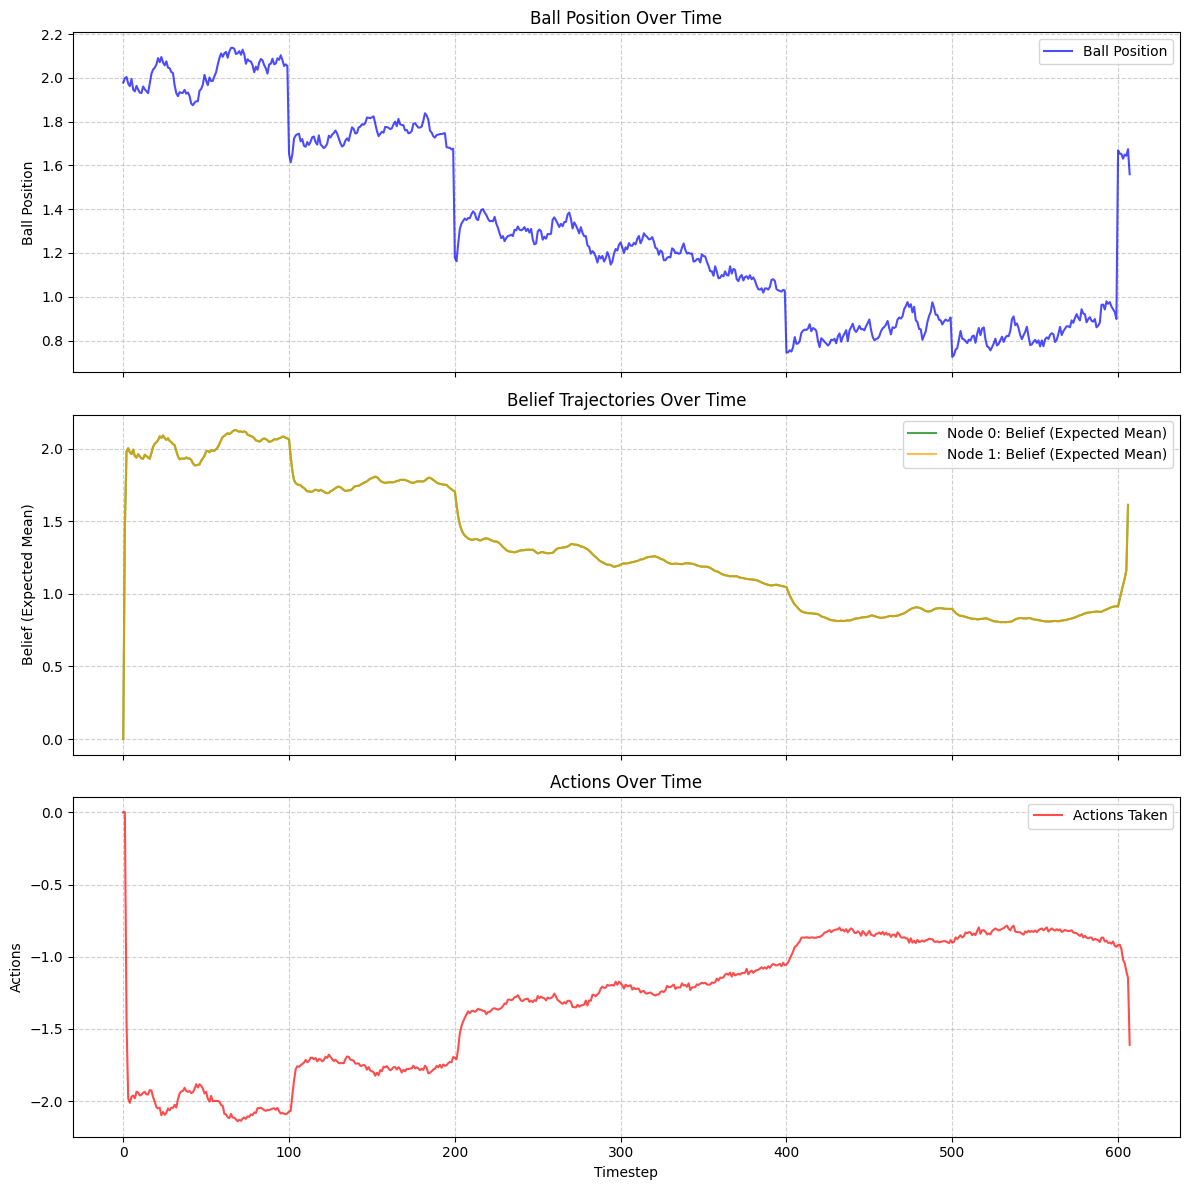

In [1541]:
# Plot the ball's position, beliefs, and actions in one figure
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Ball's position (using updated_input_data)
axs[0].plot(updated_input_data, label="Ball Position", color="blue", alpha=0.7)
axs[0].set_ylabel("Ball Position")
axs[0].set_title("Ball Position Over Time")
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.6)

# Beliefs for node_0 and node_1
axs[1].plot(node_0_expected_mean, label="Node 0: Belief (Expected Mean)", color="green", alpha=0.7)
axs[1].plot(node_1_expected_mean, label="Node 1: Belief (Expected Mean)", color="orange", alpha=0.7)
axs[1].set_ylabel("Belief (Expected Mean)")
axs[1].set_title("Belief Trajectories Over Time")
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.6)

# Actions taken
axs[2].plot(actions, label="Actions Taken", color="red", alpha=0.7)
axs[2].set_xlabel("Timestep")
axs[2].set_ylabel("Actions")
axs[2].set_title("Actions Over Time")
axs[2].legend()
axs[2].grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Causal agent

In [1542]:
# Initialize a causal HGF
causal_hgf = (
    Network()
    .add_nodes(precision=1e4, n_nodes=2, tonic_volatility = 2)
    .add_nodes(value_children=0, precision=1e4)
    .add_nodes(value_children=1, precision=1e4)
)
# Add the coupling strength in the node attributes
causal_hgf.attributes[0]["causal_coupling_children"] = jnp.array([0.0])

# Update the edges variable so it stores the index of the causal child
edges = list(causal_hgf.edges)
adjacency_list = edges[0]

# Create a new adjacency variable for this case
class CausalAdjacencyLists(NamedTuple):
    node_type: int
    value_parents: Optional[Tuple]
    volatility_parents: Optional[Tuple]
    value_children: Optional[Tuple]
    volatility_children: Optional[Tuple]
    coupling_fn: Tuple[Optional[Callable], ...]
    causal_children: Optional[Tuple]


causal_adjacency_list = CausalAdjacencyLists(
    node_type=adjacency_list.node_type,
    value_parents=adjacency_list.value_parents,
    volatility_parents=adjacency_list.volatility_parents,
    value_children=adjacency_list.value_children,
    volatility_children=adjacency_list.volatility_children,
    coupling_fn=adjacency_list.coupling_fn,
    causal_children=(1,),
)

# Insert the new variable back to the edges
edges[0] = causal_adjacency_list
causal_hgf.edges = tuple(edges)

# Add this step at the end of the belief propagation sequence
# Here we simply re-use the previous sequence as template
predictions, updates = non_causal_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
causal_hgf.update_sequence = (predictions, updates)
causal_hgf = causal_hgf.create_belief_propagation_fn()


In [ ]:

# Extract network attributes
attributes, edges, update_sequence = causal_hgf.get_network()

# Define input data
updated_input_data = x1.copy()  # Placeholder for updated data
actions = [0.0]  # Initialize actions

# Storage for metrics
node_0_expected_mean = []
node_1_expected_mean = []
node_0_precision = []
node_1_precision = []
node_0_prediction_error = []
node_1_prediction_error = []

# Define action computation parameters
proportional_gain = 1.0

for t in range(len(coupling)):

    # Predict and act: get prediction and act based on that
    noise = np.random.normal(0, 0.01) 
    action = -proportional_gain * attributes[0]["expected_mean"] + noise
    action = np.random.uniform(low=-1, high=1)
    if np.isnan(attributes[0]["expected_mean"]):
        print(t)
    attributes[0]["expected_mean"] = 0.0  # Or a safe default

    actions.append(action)

    # Update observations and OBSERVE
    updated_input_data[t] += actions[t] * coupling[t]
    

    # Prepare inputs for belief propagation
    inputs = tuple(np.column_stack((updated_input_data[t], actions[t] * np.ones_like(updated_input_data[t]))).ravel())

    # Propagate beliefs, UPDATE
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=(*inputs, 1.0),
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=causal_hgf.input_idxs,
    )

    # Store Node 0 metrics
    node_0_expected_mean.append(attributes[0]["expected_mean"])
    node_0_precision.append(attributes[0]["precision"])
    node_0_prediction_error.append(attributes[0]["temp"]["value_prediction_error"])

    # Store Node 1 metrics
    node_1_expected_mean.append(attributes[1]["expected_mean"])
    node_1_precision.append(attributes[1]["precision"])
    node_1_prediction_error.append(attributes[1]["temp"]["value_prediction_error"])



(1.9782873879339888, 0.0)
(1.9982342968656606, 0.6143835189963014)
(2.0038938668267003, -0.8890052736473202)
(1.9737679725483386, -0.04284571297631645)
4
(1.9621959675089677, 0.8392618643616134)
5
(1.9952246982509108, -0.2897277734085315)
6
(1.9466911133830493, -0.7813422454314733)
7
(1.9381128608059257, -0.5935408519600742)
8
(1.9634315859800364, 0.9740621787334762)
9
(1.9460967779347345, -0.9858630513441513)
10
(1.9325190549022933, -0.8687391027915985)
11
(1.9306248755235556, 0.2876500048508188)
12
(1.9604526680460412, 0.743248862902101)
13
(1.9476746281123483, 0.12585365610253985)
14
(1.938794988919427, -0.7039100569731662)
15
(1.9301079634070566, -0.05613598743983328)
16
(1.9742265650615658, 0.5629626696852532)
17
(2.0179622868410414, -0.4682954251303113)
18
(2.038043364798619, -0.7935485949406726)
19
(2.045767092782116, 0.6219575342280017)
20
(2.060514464300041, -0.820031074933506)
21
(2.090329104863057, 0.022013355546370628)
22
(2.071612427495009, -0.6534142974705492)
23
(2.09512

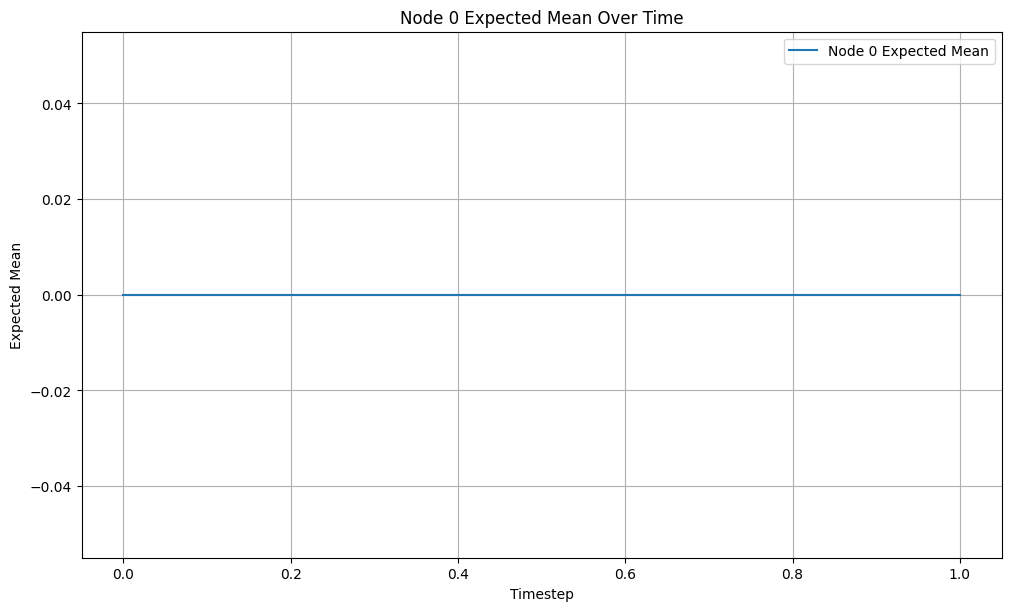

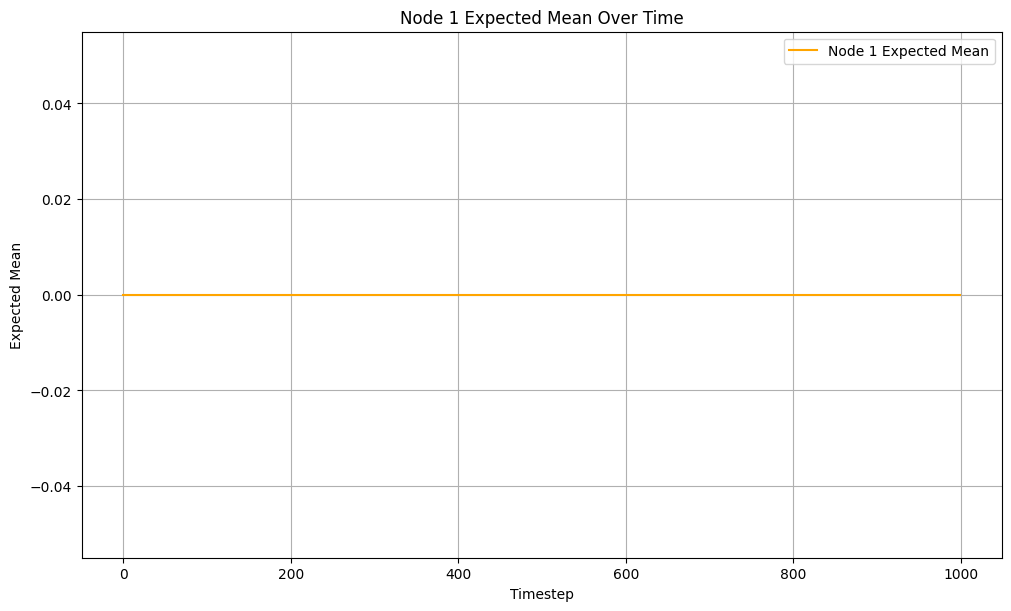

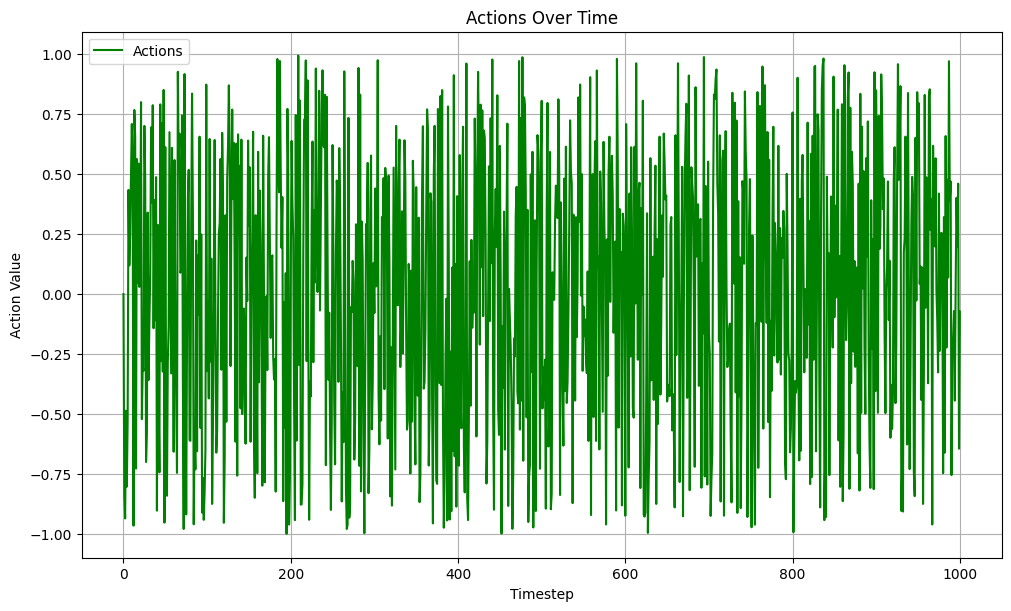

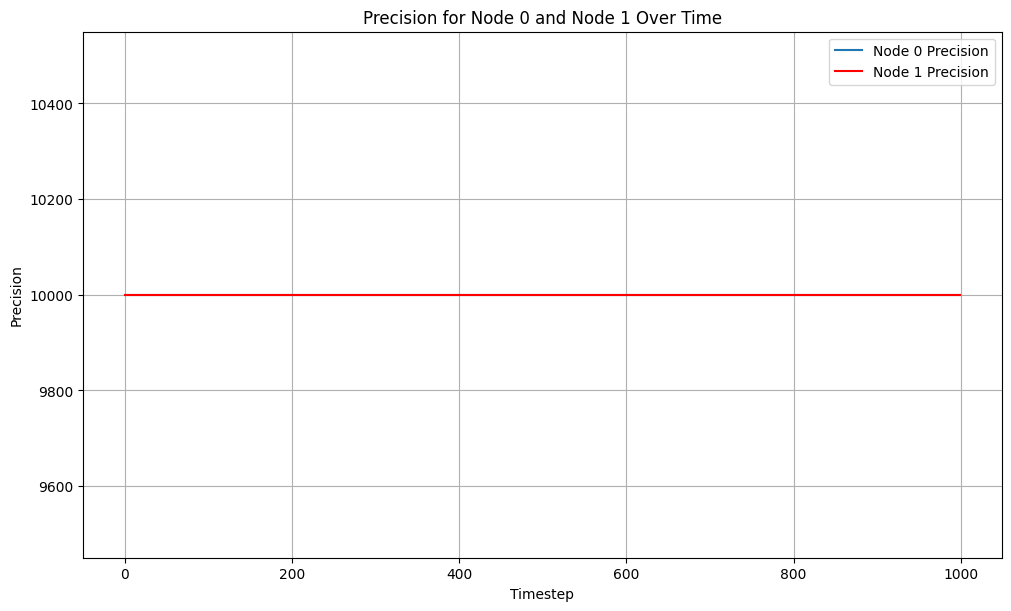

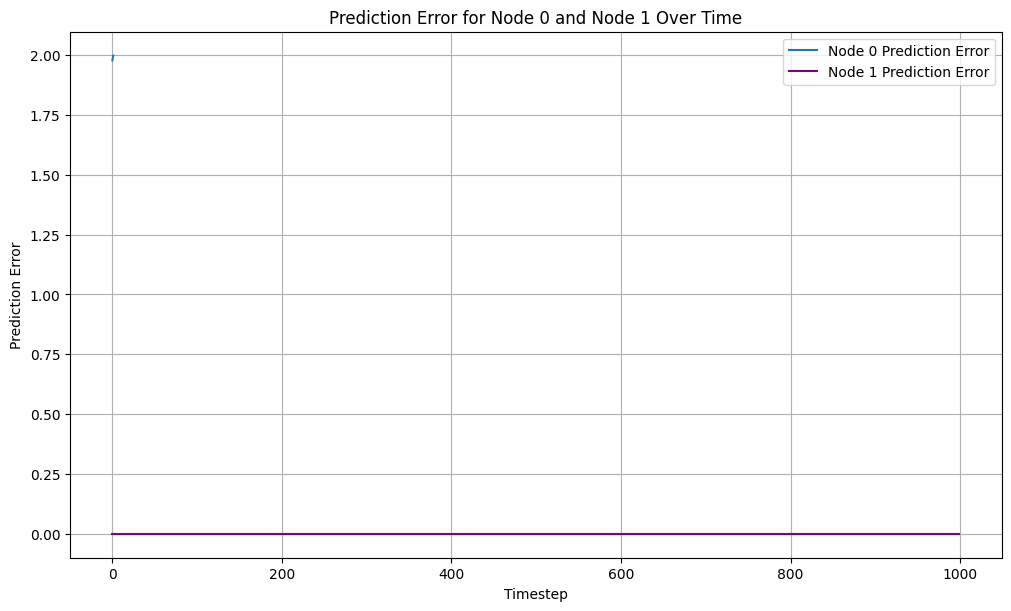

In [1544]:
# Plot Node 0 expected mean
plt.figure(figsize=(10, 6))
plt.plot(node_0_expected_mean, label='Node 0 Expected Mean')
plt.title('Node 0 Expected Mean Over Time')
plt.xlabel('Timestep')
plt.ylabel('Expected Mean')
plt.legend()
plt.grid()
plt.show()

# Plot Node 1 expected mean
plt.figure(figsize=(10, 6))
plt.plot(node_1_expected_mean, label='Node 1 Expected Mean', color='orange')
plt.title('Node 1 Expected Mean Over Time')
plt.xlabel('Timestep')
plt.ylabel('Expected Mean')
plt.legend()
plt.grid()
plt.show()

# Plot actions
plt.figure(figsize=(10, 6))
plt.plot(actions, label='Actions', color='green')
plt.title('Actions Over Time')
plt.xlabel('Timestep')
plt.ylabel('Action Value')
plt.legend()
plt.grid()
plt.show()

# Plot precision for Node 0 and Node 1
plt.figure(figsize=(10, 6))
plt.plot(node_0_precision, label='Node 0 Precision')
plt.plot(node_1_precision, label='Node 1 Precision', color='red')
plt.title('Precision for Node 0 and Node 1 Over Time')
plt.xlabel('Timestep')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# Plot prediction error for Node 0 and Node 1
plt.figure(figsize=(10, 6))
plt.plot(node_0_prediction_error, label='Node 0 Prediction Error')
plt.plot(node_1_prediction_error, label='Node 1 Prediction Error', color='purple')
plt.title('Prediction Error for Node 0 and Node 1 Over Time')
plt.xlabel('Timestep')
plt.ylabel('Prediction Error')
plt.legend()
plt.grid()
plt.show()

In [1545]:
# Get network parameters
attributes, edges, update_sequence = causal_hgf.get_network()

# Simulation parameters
n_samples = 1000
noise_level = 0.1
proportional_gain = 0.01  # Define proportional gain
input_data = x1.copy()  # Copy x1 as the initial input data

# Initialize storage for metrics
node_0_expected_mean = [] 
node_1_expected_mean = []  
node_0_precision = []   
node_1_precision = []     
node_0_expected_precision = []  
node_1_expected_precision = []  
node_0_prediction_error = []   
node_1_prediction_error = []  
actions = np.zeros(n_samples) 

# Simulation loop
for t in range( n_samples):
    # ACT: Determine the action based on the prediction
    action = -proportional_gain * attributes[0]["expected_mean"].item()
    actions[t] = action


    # OBSERVE: Update the observation based on the action and system dynamics
    input_data[t] = input_data[t - 1] + action * coupling[t]
    data = np.array([input_data, actions])

    # Update the network (prediction error and belief update)
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=(*data,1.0),
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=causal_hgf.input_idxs,
    )

    # Store metrics for node_0 (x1)
    node_0_expected_mean.append(attributes[0].get("expected_mean", np.nan))
    node_0_precision.append(attributes[0].get("precision", np.nan))
    node_0_expected_precision.append(attributes[0].get("expected_precision", np.nan))
    node_0_prediction_error.append(attributes[0]["temp"].get("value_prediction_error", np.nan))

    # Store metrics for node_1 (x2 or actions)
    node_1_expected_mean.append(attributes[1].get("expected_mean", np.nan))
    node_1_precision.append(attributes[1].get("precision", np.nan))
    node_1_expected_precision.append(attributes[1].get("expected_precision", np.nan))
    node_1_prediction_error.append(attributes[1]["temp"].get("value_prediction_error", np.nan))

# Visualization
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Ball's position (x1)
axs[0].plot(input_data, label="Ball Position (x1)", color="blue", alpha=0.7)
axs[0].set_ylabel("Ball Position")
axs[0].set_title("Ball Position Over Time")
axs[0].legend()
axs[0].grid(True, linestyle="--", alpha=0.6)

# Beliefs for node_0 (input) and node_1 (action)
axs[1].plot(node_0_expected_mean, label="Node 0: Belief (x1)", color="green", alpha=0.7)
axs[1].plot(node_1_expected_mean, label="Node 1: Belief (x2)", color="orange", alpha=0.7)
axs[1].set_ylabel("Belief (Expected Mean)")
axs[1].set_title("Belief Trajectories Over Time")
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.6)

# Actions
axs[2].plot(actions, label="Actions Taken (x2)", color="red", alpha=0.7)
axs[2].set_ylabel("Actions")
axs[2].set_title("Actions Over Time")
axs[2].legend()
axs[2].grid(True, linestyle="--", alpha=0.6)

# Prediction errors
axs[3].plot(node_0_prediction_error, label="Node 0: Prediction Error", color="purple", alpha=0.7)
axs[3].plot(node_1_prediction_error, label="Node 1: Prediction Error", color="brown", alpha=0.7)
axs[3].set_ylabel("Prediction Error")
axs[3].set_title("Prediction Errors Over Time")
axs[3].legend()
axs[3].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


AttributeError: 'float' object has no attribute 'item'

In [ ]:
print(input_data[0])

-0.03548447098774551


/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_11255/97835245.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


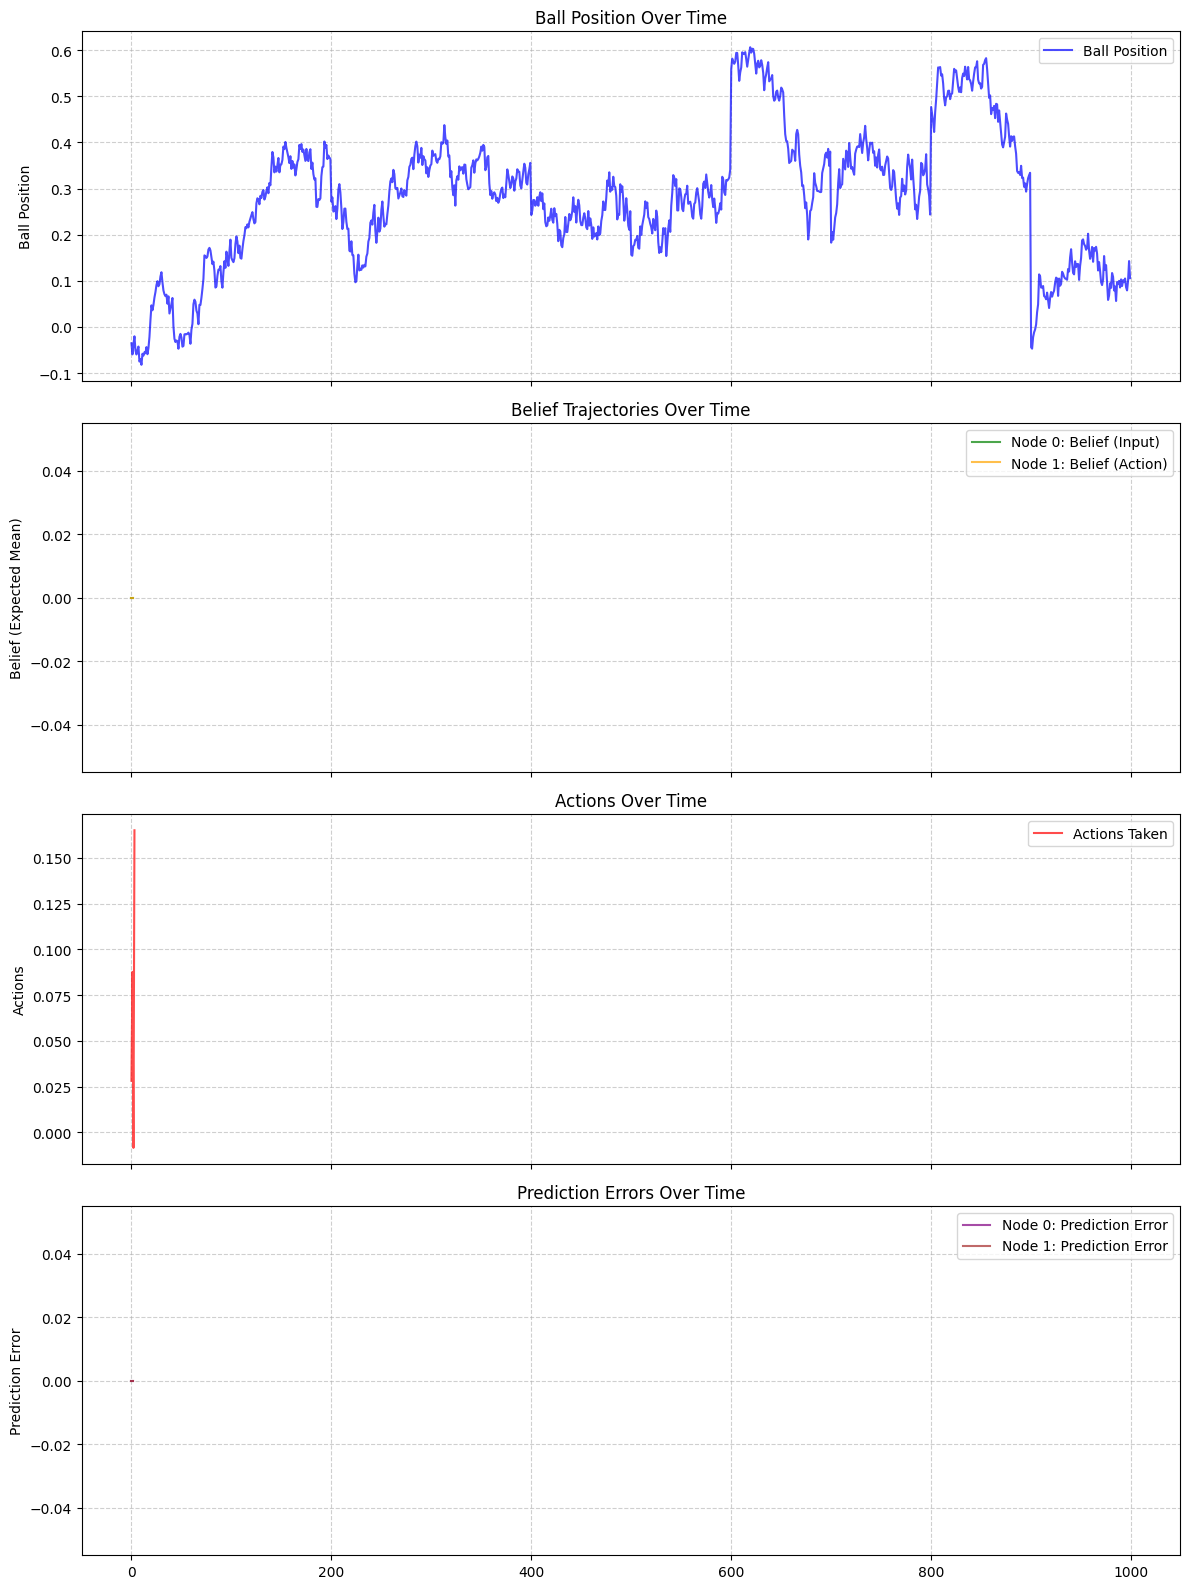

In [ ]:
# Visualization
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Ball's position
axs[0].plot(updated_input_data, label="Ball Position", color="blue", alpha=0.7)
axs[0].set_ylabel("Ball Position")
axs[0].set_title("Ball Position Over Time")
axs[0].legend()
axs[0].grid(True, linestyle="--", alpha=0.6)

# Beliefs for node_0 (input) and node_1 (action)
axs[1].plot(node_0_expected_mean, label="Node 0: Belief (Input)", color="green", alpha=0.7)
axs[1].plot(node_1_expected_mean, label="Node 1: Belief (Action)", color="orange", alpha=0.7)
axs[1].set_ylabel("Belief (Expected Mean)")
axs[1].set_title("Belief Trajectories Over Time")
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.6)

# Actions
axs[2].plot(actions, label="Actions Taken", color="red", alpha=0.7)
axs[2].set_ylabel("Actions")
axs[2].set_title("Actions Over Time")
axs[2].legend()
axs[2].grid(True, linestyle="--", alpha=0.6)

# Prediction errors
axs[3].plot(node_0_prediction_error, label="Node 0: Prediction Error", color="purple", alpha=0.7)
axs[3].plot(node_1_prediction_error, label="Node 1: Prediction Error", color="brown", alpha=0.7)
axs[3].set_ylabel("Prediction Error")
axs[3].set_title("Prediction Errors Over Time")
axs[3].legend()
axs[3].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()

## System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Dec 04 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pyhgf : 0.0.0
jax   : 0.4.35
jaxlib: 0.4.35

sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
numpy     : 1.26.0
scipy     : 1.14.1
pandas    : 2.2.3
pyhgf     : 0.0.0
matplotlib: 3.9.2
IPython   : 8.29.0
jax       : 0.4.35
seaborn   : 0.13.2

Watermark: 2.5.0

